In [1]:
import sys
sys.path.append('../../Dataset-Management-Library/mimic3wfdb')
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import signal_process as sp

In [2]:
dataset = np.load('../dataset/2312261000_dataset.npy', allow_pickle=True)
dataset.shape

(520, 625, 2)

## PLETH

In [3]:
def detect(dataset, v_sense=0.15):
    b, a = signal.butter(4, 8, 'lp', fs=125)
    y = signal.filtfilt(b, a, dataset)

    yd1 = sp.derivative(y)

    pd1 = sp.PeakDetector(alpha1=100, alpha2=40, beta=0.)
    pd1.fit(dataset.reshape(-1,1))
    peak, _ = pd1.detect_pv()

    pd2 = sp.PeakDetector(alpha1=100, alpha2=30, beta=0.18)
    pd2.fit(yd1.reshape(-1,1))
    peak_d1, _ = pd2.detect_pv()

    valley = np.array(list(map(lambda xs: np.argmin(dataset[xs])+xs[0], map(lambda x: np.arange(x-round(v_sense*125), x), peak_d1.reshape(-1,1)))))
    valley[np.where(valley<0)] = 0
    return peak, peak_d1, valley

In [4]:
points = np.array(list(map(detect, dataset[:,:,0])), dtype=object)
points.shape

(520, 3)

7 7 7


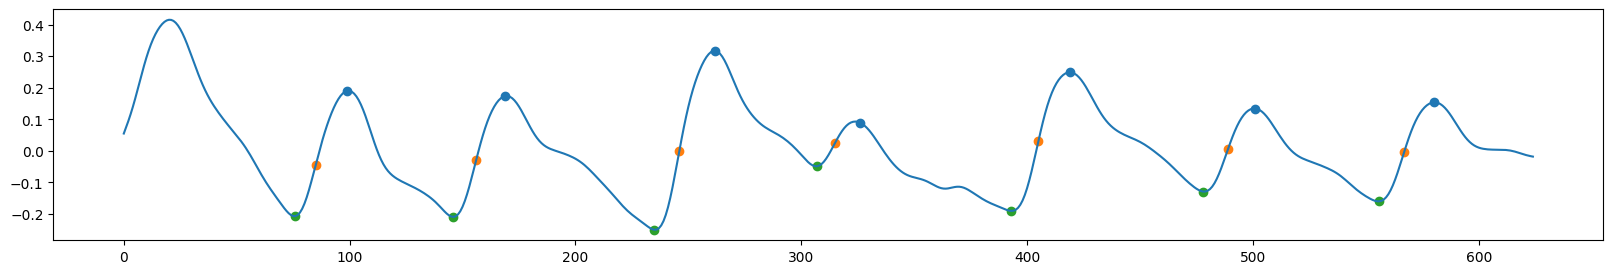

In [5]:
IDX = 89
print(points[IDX,0].size, points[IDX,1].size, points[IDX,2].size)
fig, axs = plt.subplots(1,1,figsize=(20,3))
axs.plot(dataset[IDX,:,0])
axs.scatter(points[IDX,0], dataset[IDX,points[IDX,0],0], label='n_A')
axs.scatter(points[IDX,1], dataset[IDX,points[IDX,1],0], label='n_a')
axs.scatter(points[IDX,2], dataset[IDX,points[IDX,2],0], label='n_v')
plt.show()

## ABP

In [6]:
abp_points = np.array(list(map(detect, dataset[:,:,1])), dtype=object)
abp_points.shape

(520, 3)

8 8 8


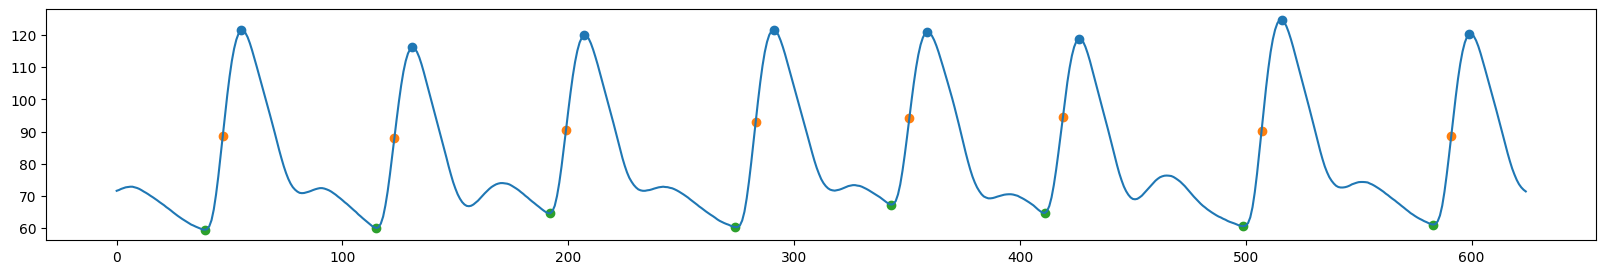

In [7]:
IDX = 20
print(abp_points[IDX,0].size, abp_points[IDX,1].size, abp_points[IDX,2].size)
fig, axs = plt.subplots(1,1,figsize=(20,3))
axs.plot(dataset[IDX,:,1])
axs.scatter(abp_points[IDX,0], dataset[IDX,abp_points[IDX,0],1], label='n_A')
axs.scatter(abp_points[IDX,1], dataset[IDX,abp_points[IDX,1],1], label='n_a')
axs.scatter(abp_points[IDX,2], dataset[IDX,abp_points[IDX,2],1], label='n_v')
plt.show()

In [8]:
sbp = dataset[IDX,abp_points[IDX,0],1].reshape(-1,1)
dbp = dataset[IDX,abp_points[IDX,2],1].reshape(-1,1)
print(sbp, dbp)
mbp = (sbp + 2*dbp)/3
print(mbp)

[[121.426443221171]
 [116.20012406402486]
 [119.91227598872679]
 [121.67066374253297]
 [120.98684628271945]
 [118.88654979900652]
 [124.74784231169377]
 [120.35187292717833]] [[59.492119003775656]
 [60.02940415077199]
 [64.620749952377]
 [60.322468776406346]
 [67.30717568735867]
 [64.71843816092179]
 [60.61553340204071]
 [61.10397444476465]]
[[80.13689374290743]
 [78.75297745518962]
 [83.05125863116025]
 [80.77186709844855]
 [85.2003992191456]
 [82.77447537361671]
 [81.9929697052584]
 [80.85327393890255]]


## Cleaning

- Peak와 Valley가 1개 이상 차이 나는 경우
- Slapničar, G.; Luštrek, M.; Marinko, M. Continuous blood pressure estimation from PPG signal. Informatica 2018, 42. 논문의 기준을 벗어나는 경우.

In [9]:
# 마지막으로 PLETH 이상한 신호 거르기
check = []
for i, point in enumerate(points):
    if point[0].size-1 <= point[1].size <= point[0].size+1: continue
    else: check.append(i)

# 마지막으로 ABP 이상한 신호 거르기
for i, point in enumerate(abp_points):
    if point[0].size-1 <= point[1].size <= point[0].size+1: continue
    else: check.append(i)

check

[280, 331, 484, 89, 342, 343, 411]

In [10]:
dataset = np.delete(dataset, check, axis=0)
points = np.delete(points, check, axis=0)
abp_points = np.delete(abp_points, check, axis=0)
dataset.shape, points.shape, abp_points.shape

((513, 625, 2), (513, 3), (513, 3))

In [11]:
sbp = np.array([dataset[i,abp_points[i,0],1].mean() for i in range(len(abp_points))])
dbp = np.array([dataset[i,abp_points[i,2],1].mean() for i in range(len(abp_points))])

In [12]:
check2 = []
check2.extend(list(np.where(sbp < 80)[0]))
check2.extend(list(np.where(sbp > 250)[0]))

In [13]:
check2.extend(list(np.where(dbp < 40)[0]))
check2.extend(list(np.where(dbp > 150)[0]))

In [14]:
check2.extend(list(np.where(sbp-dbp < 20)[0]))

In [15]:
check2 = np.array(list(set(check2)))
check2.shape

(45,)

In [16]:
dataset = np.delete(dataset, check2, axis=0)
points = np.delete(points, check2, axis=0)
abp_points = np.delete(abp_points, check2, axis=0)
dataset.shape, points.shape, abp_points.shape

((468, 625, 2), (468, 3), (468, 3))

In [17]:
np.save('../dataset/2312271100_dataset.npy', dataset)
np.save('../dataset/2312271100_pleth_points.npy', points)
np.save('../dataset/2312271100_abp_points.npy', abp_points)